In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1A. Schechter function:
$$ \phi(L) = (\frac{\phi_*}{L_*}) \exp(-\frac{L}{L_*}) (\frac{L}{L_*})^\alpha$$
Since we will just be looking for fractions of the cumulative function, the normalization doessn't matter, and we have:
$$ \phi(L) \propto (\frac{L}{L_*})^\alpha \exp(-\frac{L}{L_*}) $$
If we make the approximation that a single power law represents the luminosity function (as was suggested that you can do, but see below for numerical calculation), using $\alpha$=-1, and removing exponential term:
$$\int_{L_1/L_*}^{L_2/L_*} (\frac{L}{L_*})^{-1} dL = \ln \frac{L_2}{L_*} - \ln \frac{L_1}{L_*}$$

We have $M_{lo}=-5$, $M_{hi}=-23$, $M_*=-21$, $L/L_* = 10^{(-0.4 (M-M_*))}$

$$\int_{L_{lo}/L_*}^{L_{hi}/L_*} L^{-1} dL \propto \ln (\frac{L_{hi}}{L_*}) - \ln (\frac{L_{lo}}{L_*}) $$

In [2]:
#analytic solution assuming power law, get total integral first
mlo=-5
mhi=-23
mstar=-21
lhi = 10**(-0.4*(mhi-mstar))
llo = 10**(-0.4*(mlo-mstar))
tot=np.log(lhi)-np.log(llo)
print('total: ', tot)

total:  16.57861266955713


Now get the 25, 50, and 75th percentiles:
$$\int_{L_{lo}/L_*}^{L_p/L_*} (\frac{L}{L_*})^{-1} dL = \ln L_p/L_* - \ln L_{lo}/L* = (p) (tot)$$


In [3]:
for perc in [0.25, 0.5, 0.75] :
    lum = np.exp(perc*tot + np.log(llo))
    m = -2.5*np.log10(lum) + mstar
    print('{:.2f} {:.2f}'.format(perc,m))

0.25 -9.50
0.50 -14.00
0.75 -18.50


If we include the exponential term, you can do the integral numerically:

In [4]:
def phi(m,mstar=-21,alpha=-1) :
    """Schechter function in magnitudes"""
    return 10.**(-0.4*(alpha+1)*(m-mstar))*np.exp(-10.**(-0.4*(m-mstar)))
    

# simple integral over full range, using small steps
tot=0.
for m in np.arange(-5,-23,-0.001) :
  tot+=phi(m)

# now do it to get the percentiles to nearest 0.001
tmp=0.
p=0.25
for m in np.arange(-5,-23.001,-0.001) :
  tmp+=phi(m)
  if tmp/tot > p :
    print('{:.2f} {:.2f}'.format(p,m))
    p+=0.25


0.25 -8.84
0.50 -12.69
0.75 -16.55
1.00 -23.00


However, note that if you express the Schechter function in magnitudes:
$$\phi(M) \propto 10^{-0.4 (\alpha+1) (M-M_*)} \exp(-10^{-0.4 (M-M_*)})$$
then, for $\alpha=-1$, you have
$$\phi(M) \propto \exp(-10^{-0.4 M})$$
and you can integrate analytically

1B. To get luminosity integral ($\phi_L$), multiply number at each luminosity by the luminosity:
$$ \phi_L(L) = L (\frac{\phi_*}{L_*}) \exp(-\frac{L}{L_*}) (\frac{L}{L_*})^\alpha$$
For the case of $\alpha = -1$, this is particularly easy, since the $L$ cancels:
$$ \phi_L(L) \propto \exp(-\frac{L}{L_*})$$
So the integral is easy and analytic without any approximation:

$$\int_{L_{lo}/L_*}^{L_{hi}/L_*} \exp(-\frac{L}{L_*}) dL =  -\exp (-\frac{L_{hi}}{L_*}) + \exp(-\frac{L_{lo}}{L_*}) $$

In [5]:
tot=-np.exp(-lhi)+np.exp(-llo)

for perc in [0.25, 0.5, 0.75] :
    lum = -np.log(-perc*tot + np.exp(-llo))
    m = -2.5*np.log10(lum) + mstar
    print('{:.2f} {:.2f}'.format(perc,m))

0.25 -19.64
0.50 -20.60
0.75 -21.35


1C. These results show that the bulk of the number of galaxies are at low luminosity, but the bulk of the luminosity comes from higher luminosity galaxies


select galaxy properties from SDSS

In [6]:
from astroquery.sdss import SDSS
zmin=0.015
zmax=0.05
sql=' SELECT \
      objid,ra,dec,petroMag_g,petroMag_r, \
      extinction_g,extinction_r,z,class \
      FROM SpecPhotoAll \
    WHERE \
      z > {:f} AND z < {:f} AND class = "GALAXY" \
      AND (ra between 140 and 240) and (dec between 0 and 50)'.format(zmin,zmax)
dr17=SDSS.query_sql(sql, data_release=17) 

print(len(dr17))

/Users/holtz/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


62710


/Users/holtz/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:877: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


Determine absolute magnitudes, first correcting for foreground extinction, then using distances from Hubble law

(-0.1, 1.2)

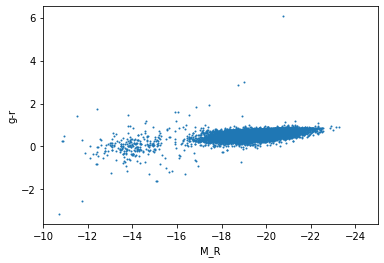

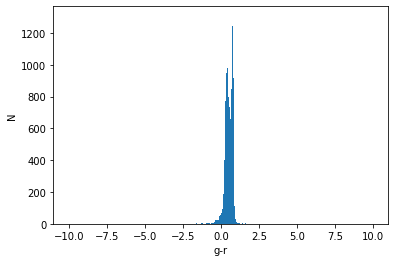

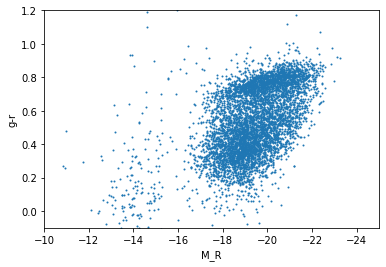

In [8]:
#distances from Hubble law
c=3.e5  # km/s
h0=70   # km/s/Mpc
dist=dr17['z']*c/h0  # distance in Mpc

# correct for extinction and distance to get absolute magnitude
# in Mpc, m-M = 5 log d + 25
r=dr17['petroMag_r']-dr17['extinction_r']-5*np.log10(dist)-25
g=dr17['petroMag_g']-dr17['extinction_g']-5*np.log10(dist)-25


# plot color vs absolute mag, every 10th point to see structure
plt.scatter(r[::10],g[::10]-r[::10],s=1)
plt.xlabel('M_R')
plt.ylabel('g-r')
plt.xlim(-10,-25)

#color histogram to look for bimodality
plt.figure()
out=plt.hist(g-r,bins=np.arange(-10,10,0.01))
plt.xlabel('g-r')
plt.ylabel('N')

#plot again limit range in color
plt.figure()
plt.scatter(r[::10],g[::10]-r[::10],s=1)
plt.xlabel('M_R')
plt.ylabel('g-r')
plt.xlim(-10,-25)
plt.ylim(-0.1,1.2)

Raw luminosity function, uncorrected for selection function

Text(0, 0.5, 'Number of galaxies (uncorrected)')

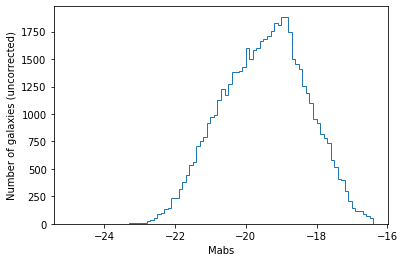

In [186]:
# hist() returns number of objects per bin, and bin edges (one element more than number of bins)
out=plt.hist(r,bins=np.arange(-25,-16.3,0.1),histtype='step')
plt.xlabel('Mabs')
plt.ylabel('Number of galaxies (uncorrected)')

Maximum volume as a function of absolute magnitude, given an apparent limiting magnitude:
$$d_{max}=10^{(m_{lim}-m_{abs}-25)/5}$$
$$v_{max}=f d_{max}^3$$
where $f$ depends on the survey geometry, i.e. what fraction of the sky is covered.

However, we also imposed a maximum redshift.

64.28571428571429 -16.270572368805432


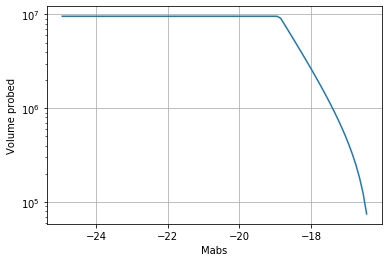

In [187]:
# center of bins into mabs
mabs=out[1][0:-1]+0.05

# maximum volume as a function of Mabs
mlim=17.77
dmax=10**((mlim-mabs-25)/5)
# we also have a cutoff in redshift by our query!
dmax[dmax>zmax*c/h0] = zmax*c/h0

# minimum volume from selection criterion of z>0.015
dmin=.015*3.e5/70
print(dmin,mlim-5*np.log10(dmin)-25)

# volume probed as a function of mabs
vol = (dmax**3-dmin**3)
plt.plot(mabs,vol)
plt.yscale('log')
plt.xlabel('Mabs')
plt.ylabel('Volume probed')
plt.grid()

To account for selection function, divide counts at each absolute magnitude by the volume probed for that absolute magnitude

Text(0, 0.5, '$\\phi$')

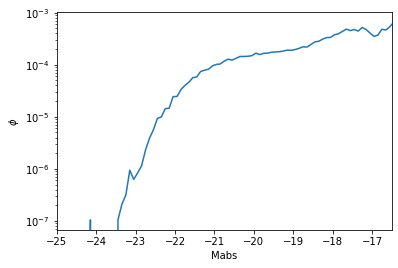

In [188]:
# corrected luminosity function
lf=out[0]/vol
plt.plot(mabs,lf)

plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('Mabs')
plt.ylabel('$\phi$')


V/V_max test is useful to check the completeness of a survey. For every object, calculate the volume in which it is found, as well as the maximum volume in which it could be found. Make a histogram of V/V_max for all objects.

/Users/holtz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


<V/Vmax>: 0.46


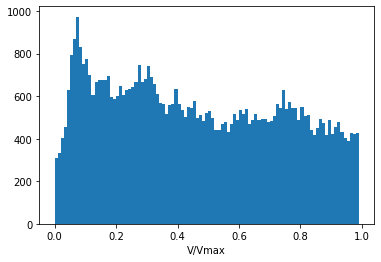

In [247]:
#volumen in which object is found
v=dist**3-dmin**3

# volume in which it could be found
dmax=10**((mlim-r-25)/5)
dmax[dmax>zmax*c/h0] = zmax*c/h0
vmax=dmax**3-dmin**3

# plot v/vmax
out=plt.hist(v/vmax,bins=np.arange(0,1,0.01))
plt.xlabel('V/Vmax')
gd=np.where((v/vmax > 0) & (v/vmax <=1))[0]
print('<V/Vmax>: {:.2f}'.format(np.mean(v[gd]/vmax[gd])))


Do a Schechter fit to the corrected luminosity function


Schechter fit:
Mstar: -21.870660 
 alpha: -1.347165 
  phistar: 0.000100
Schechter fit after remove brightest bins:
Mstar: -21.870794 
 alpha: -1.347172 
  phistar: 0.000100


Text(0, 0.5, '$\\phi$')

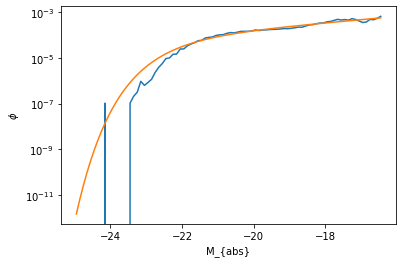

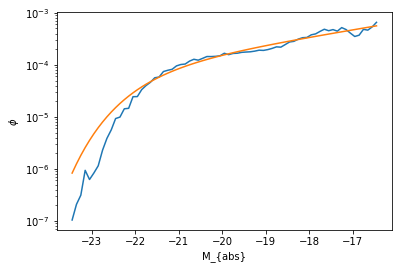

In [226]:
def schechter(m,mstar=-21,alpha=-1,phistar=1) :
    """Schechter function in magnitudes"""
    return phistar*10.**(-0.4*(alpha+1)*(m-mstar))*np.exp(-10.**(-0.4*(m-mstar)))
    

# plot the corrected LF
plt.plot(mabs,lf)
plt.yscale('log')

# do the fit with curve_fit
p0=[-21,-1,1]   # starting guess for fit
from scipy.optimize import curve_fit
pars=curve_fit(schechter,mabs,lf,p0=p0)
print('Schechter fit:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))
plt.plot(mabs,schechter(mabs,*pars[0]))
plt.xlabel('M_{abs}')
plt.ylabel('$\phi$')

# try again removing data with Mabs<-23.5
plt.figure()
gd =np.where(mabs>-23.5)[0]
pars=curve_fit(schechter,mabs[gd],lf[gd],p0=p0)
print('Schechter fit after remove brightest bins:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))
plt.plot(mabs[gd],lf[gd])
plt.yscale('log')

plt.plot(mabs[gd],schechter(mabs[gd],*pars[0]))
plt.xlabel('M_{abs}')
plt.ylabel('$\phi$')

